In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
import requests

import datetime
import time
from chinese_calendar import is_holiday
import calendar

from pandas.api.types import CategoricalDtype

In [2]:
%matplotlib inline

In [3]:
df_user_order_detail = pd.read_csv(r'../input/car8865/用户基础数据.csv',
                              dtype={'trade_order_id':object,'uid':object,'gid':object,'passenger_phone':object,'platform':object,
                                    'service_type':int,'service_type_name':object,'order_status':int,'order_status_name':object,
                                    'order_day':object,'book_day':object,'order_car_type_id':int,'order_car_type_name':object,
                                    'city_code':object,'city_name':object,'channel_id':int,'channel_name':object,
                                    'first_token_driver_taken_type':object,'first_token_driver_taken_type':object,'order_car_type_id':int,
                                     'order_car_type_name':object,'source_type':int,'source_type_name':object},encoding='utf-8')

In [4]:
df_user_order_detail.head()

,trade_order_id,uid,gid,passenger_phone,platform,service_type,service_type_name,order_status,order_status_name,order_day,...,city_code,city_name,channel_id,channel_name,first_taken_driver_taken_type,first_taken_driver_taken_type_name,order_car_type_id.1,order_car_type_name.1,source_type,source_type_name
0,E181619485232,868385039047457,BB7C5279-95E1-DA88-EC0D-9A358E56AB73,186VU265589,Q,3,城市交通（时租）,7,已确认款项,2018-08-11,...,sanya,三亚,60,Android,100,OTA司机接单,99,出租车,12,OTA
1,E181645360215,E7663F36-6C35-4DDA-BEB3-2897F4ED35BC,69093625-85FA-A7B7-F485-0C8AB5404A88,139svlo3695,Q,3,城市交通（时租）,7,已确认款项,2018-09-06,...,shanghai_city,上海,80,iPhone,100,OTA司机接单,5,商务型,12,OTA
2,E181680198260,866229036251187,9AA77171-6B71-0946-0D7A-A21D4DCE2873,186r8ar1007,Q,3,城市交通（时租）,7,已确认款项,2018-10-11,...,wuhan,武汉,60,Android,100,OTA司机接单,99,出租车,12,OTA
3,E181781813380,866693026884317,0EC31567-3910-FA5F-4B13-B1C8FB262628,138gNTQ9157,Q,3,城市交通（时租）,8,取消,2019-01-20,...,nanjing,南京,60,Android,100,OTA司机接单,99,出租车,12,OTA
4,E181787631459,273ECCB0-AA83-4766-8013-C2D22DF0D6A0,97FE372C-B013-A68E-7A17-A44FEAF7E46A,182tpRS3656,Q,2,接机,8,取消,2019-01-26,...,shenyang,沈阳,80,iPhone,100,OTA司机接单,2,舒适型,12,OTA


In [5]:
df_user_order_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
trade_order_id                        10000 non-null object
uid                                   10000 non-null object
gid                                   10000 non-null object
passenger_phone                       10000 non-null object
platform                              10000 non-null object
service_type                          10000 non-null int32
service_type_name                     10000 non-null object
order_status                          10000 non-null int32
order_status_name                     10000 non-null object
order_day                             10000 non-null object
book_day                              10000 non-null object
order_car_type_id                     10000 non-null int32
order_car_type_name                   10000 non-null object
order_order_class_id                  10000 non-null int64
order_order_class_name                10000 non-null obj

In [6]:
df_user_order_detail.duplicated().value_counts()

False    10000
dtype: int64

In [7]:
df_na = df_user_order_detail[df_user_order_detail.apply(lambda x:x==0) | (df_user_order_detail.apply(lambda x:x==0))].dropna(axis=0,how='all')
df_na.shape

(0, 25)

In [8]:
def date_extension(row):     # 如有必要，可通过ProcessPoolExecutor加速
    use_immediate = 1 if row['order_day'] == row['book_day'] else 0
    order_date_tuple = time.strptime(row['order_day'],'%Y-%m-%d')[:3]
    book_date_tuple = time.strptime(row['book_day'],'%Y-%m-%d')[:3]
#     order_month = month_short_list[order_date_tuple[1]-1]
    order_month = order_date_tuple[1]
#     book_month = month_short_list[book_date_tuple[1]-1]
    book_month = book_date_tuple[1]
    r_order_date = 1 if is_holiday(datetime.date(order_date_tuple[0],order_date_tuple[1],order_date_tuple[2])) else 0
    r_book_date = 1 if is_holiday(datetime.date(book_date_tuple[0],book_date_tuple[1],book_date_tuple[2])) else 0
    return r_order_date,r_book_date,use_immediate,order_month,book_month

In [9]:
df_user_order_detail[['is_bookdate_holiday','is_orderdate_holiday','use_immediate','order_month','book_month']] = df_user_order_detail.apply(date_extension,axis=1,result_type='expand')

In [10]:
df_user_order_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 30 columns):
trade_order_id                        10000 non-null object
uid                                   10000 non-null object
gid                                   10000 non-null object
passenger_phone                       10000 non-null object
platform                              10000 non-null object
service_type                          10000 non-null int32
service_type_name                     10000 non-null object
order_status                          10000 non-null int32
order_status_name                     10000 non-null object
order_day                             10000 non-null object
book_day                              10000 non-null object
order_car_type_id                     10000 non-null int32
order_car_type_name                   10000 non-null object
order_order_class_id                  10000 non-null int64
order_order_class_name                10000 non-null obj

In [412]:
df_user_order_detail[['is_bookdate_holiday','is_orderdate_holiday','use_immediate','order_month','book_month']]

,is_bookdate_holiday,is_orderdate_holiday,use_immediate,order_month,book_month
0,1,1,1,8,8
1,0,0,1,9,9
2,0,0,1,10,10
3,1,1,1,1,1
4,1,0,0,1,2
...,...,...,...,...,...
9995,0,0,0,8,8
9996,1,1,0,10,10
9997,0,0,0,1,1
9998,0,0,1,5,5


In [164]:
df_user_order_detail['order_day'].max()     # 2019-06-06
df_user_order_detail['order_day'].min()     # 2018-06-06

'2018-06-06'

In [11]:
plt.rcParams['font.sans-serif']=['SimHei']

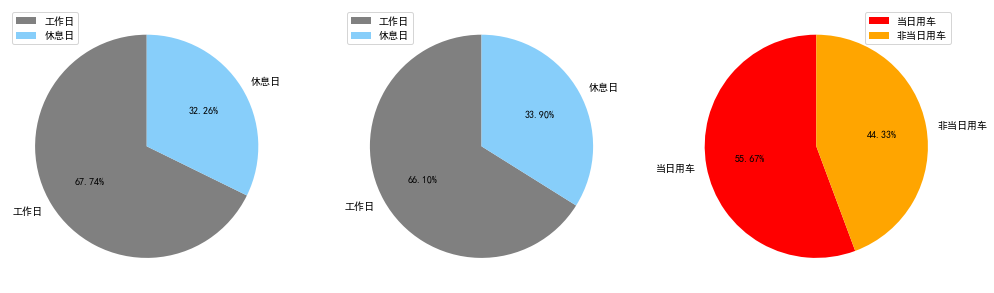

In [12]:
fig = plt.figure(figsize=(17,6))
color_list = [['gray','lightskyblue'],['gray','lightskyblue'],['red','orange']]
labels = [['工作日','休息日'],['工作日','休息日'],['当日用车','非当日用车']]
# x = np.arange(0, 100)  
for i,col in enumerate(['is_bookdate_holiday','is_orderdate_holiday','use_immediate']):
    axes = fig.add_subplot(1,3,int(i+1))
    x = df_user_order_detail[col].value_counts()
    plt.pie(x,autopct='%1.2f%%',labels=labels[i],colors=color_list[i],startangle=90)
    axes.legend(loc='best')
plt.show()

In [118]:
# 当日用车订单数
df_user_order_detail[df_user_order_detail['use_immediate']==1]['service_type_name'].value_counts()

接机          1887
城市交通（时租）    1183
送机           889
接站           374
送站           100
Name: service_type_name, dtype: int64

In [435]:
# 非当日用车订单数
df_user_order_detail[df_user_order_detail['use_immediate']==0]['service_type_name'].value_counts()

送机          2490
接机          2366
送站           269
接站           249
城市交通（时租）     193
Name: service_type_name, dtype: int64

In [524]:
df_user_order_detail[df_user_order_detail['is_bookdate_holiday']==0]['service_type_name'].value_counts()

接机          2950
送机          2235
城市交通（时租）     910
接站           418
送站           261
Name: service_type_name, dtype: int64

##### 工作日，当日用车占比相对高
##### 当日用车中，接客数量高于送客数量，非当日用车则反之

In [13]:
# 根据用车月份手动指定顺序，尝试过数字，英文，中文字设置自定义排序，均无法满足要求

In [14]:
# se_order_month = pd.CategoricalDtype(['七月','八月','九月','十月','十一月','十二月','一月','二月','三月','四月','五月','六月'],ordered=True)

In [15]:
# df_user_order_detail['book_month'].astype(se_order_month,inplace=True)

In [16]:
# df_user_order_detail.sort_values('book_month',ascending=True)

In [218]:
# def se_book_time_ordered(se):
#     print(se)
#     se_new = pd.concat(se.sort_index()[6:],se.sort_index()[:6])
#     return se_new

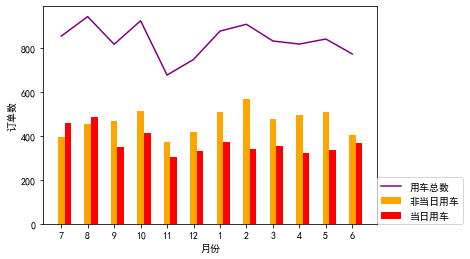

In [385]:
se_非当日用车笔数月份统计_用车日期顺序 = df_user_order_detail[df_user_order_detail['use_immediate']==0]['book_month'].value_counts()
se_当日用车笔数月份统计_用车日期顺序 = df_user_order_detail[df_user_order_detail['use_immediate']==1]['book_month'].value_counts()
y_0 = pd.concat([se_非当日用车笔数月份统计_用车日期顺序.sort_index()[6:],se_非当日用车笔数月份统计_用车日期顺序.sort_index()[:6]])
y_1 = pd.concat([se_当日用车笔数月份统计_用车日期顺序.sort_index()[6:],se_当日用车笔数月份统计_用车日期顺序.sort_index()[:6]])
y_2 = pd.concat([df_user_order_detail['book_month'].value_counts().sort_index()[6:],
                df_user_order_detail['book_month'].value_counts().sort_index()[:6]])
x1 = np.arange(1,13)
x2 = x1+0.25
plt.bar(x1,y_0,width=0.25,color='orange',tick_label=y_0.index.to_list(),label='非当日用车')
plt.bar(x2,y_1,width=0.25,color='red',label='当日用车')
plt.plot(x1,y_2,label='用车总数',color='purple')
plt.xlabel('月份')
plt.ylabel('订单数')
plt.xticks(ticks=x1,labels=y_0.index.to_list(),rotation=0)
plt.legend(bbox_to_anchor=(1,0),loc=3,borderaxespad=0)

In [343]:
df_service_type_match_name = pd.read_csv(r'../input/car8865/服务类型数据.csv',usecols=['service_type','service_type_name'],
                                         dtype={'servcie_type':int,'servcie_type_name':object})
service_type_list = df_user_order_detail['service_type'].value_counts().index.to_list()
service_type_name_list = df_service_type_match_name.query('service_type in @service_type_list').sort_values('service_type')['service_type_name']
service_type_name_list

0          送机
1          接机
2    城市交通（时租）
3          送站
4          接站
Name: service_type_name, dtype: object

In [421]:
df_service_type_each_month = df_user_order_detail.groupby(['service_type','order_month']).count()['trade_order_id']

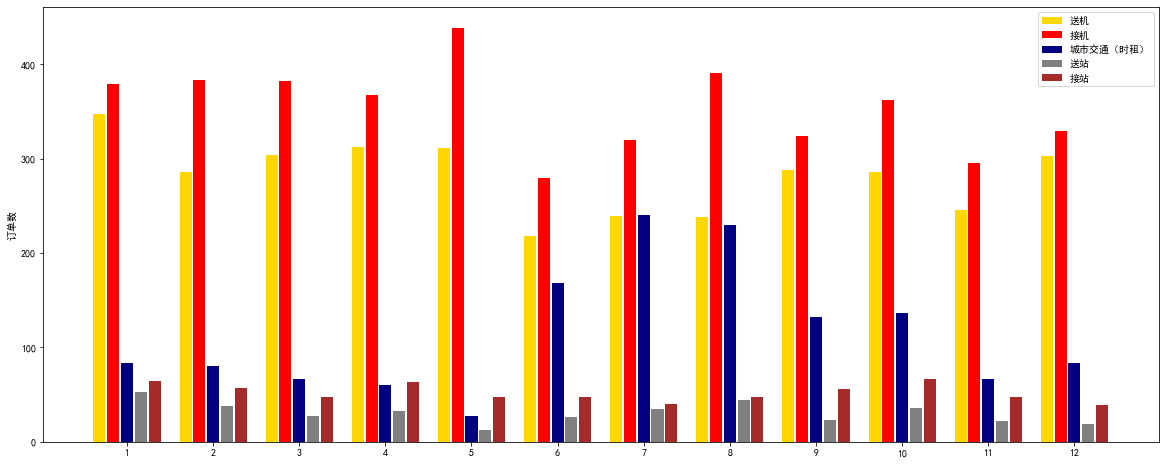

In [437]:
plt.figure(figsize=(20,8))
x = np.arange(len(df_service_type_each_month.xs(1)))
width = 0.14
color_list = ['gold','red','navy','gray','brown']
label_list = service_type_name_list
for i,se_ind in enumerate(range(-2,3)):
    rect1 = plt.bar(x+(width+0.02)*se_ind,df_service_type_each_month.xs((i+1)).values,width,label=label_list[i],color=color_list[i])
plt.xticks(x,labels=df_service_type_each_month.xs(1).index)
plt.ylabel('订单数')
plt.legend(loc='best')

##### 6,7,8月外，当日用车订单数有所下降（疑似天气转凉，市内用车需求下降所致）
##### 1月送机和送站单数高于其他月份（春运？）
##### 租车往来机场业务明显多于租车往来车站业务，而接机在所有订单类型中占比最高
##### 备注：6月有订单正在进行中

In [159]:
list_order_city_top10 = df_user_order_detail['city_name'].value_counts().head(10).index.to_list()
list_order_city_top10

['北京', '上海', '成都', '西安', '重庆', '广州', '三亚', '深圳', '杭州', '昆明']

In [443]:
df_order_cities_each_type = df_user_order_detail.query('city_name in @list_order_city_top10').groupby(['service_type','city_name']).count()['trade_order_id']
# df_order_cities_each_type
df_service_kind_each_city = df_user_order_detail.query('city_name in @list_order_city_top10').groupby(['city_name','service_type']).count()['trade_order_id']
# df_service_kind_each_city

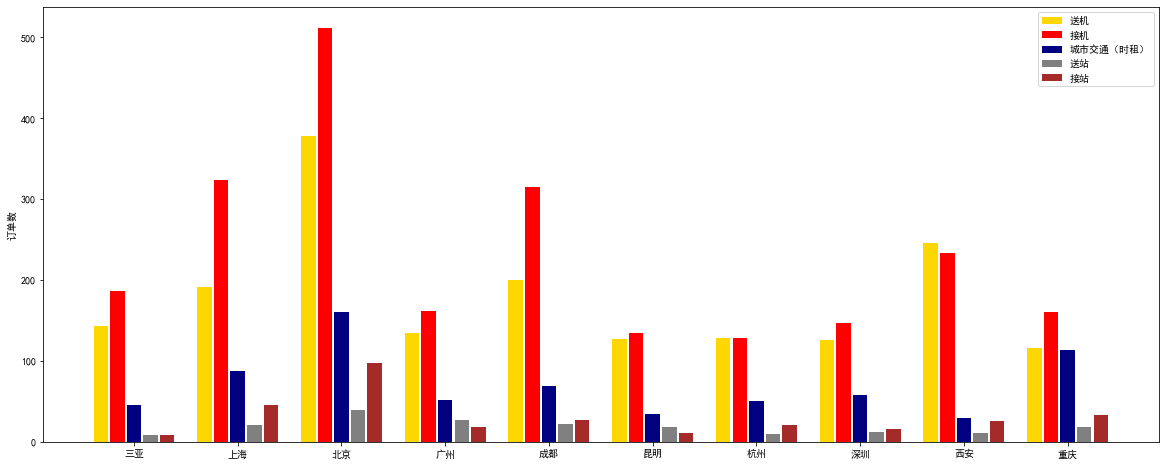

In [444]:
plt.figure(figsize=(20,8))
x = np.arange(len(df_order_cities_each_type.xs(1)))
width = 0.14
color_list = ['gold','red','navy','gray','brown']
label_list = service_type_name_list
for i,se_ind in enumerate(range(-2,3)):
    rect1 = plt.bar(x+(width+0.02)*se_ind,df_order_cities_each_type.xs((i+1)).values,width,label=label_list[i],color=color_list[i])
plt.xticks(x,labels=df_order_cities_each_type.xs(5).sort_index().index.to_list())
plt.ylabel('订单数')
plt.legend(loc='best')

In [462]:
df_user_order_detail[df_user_order_detail['service_type']==3]['city_name'].value_counts().head(10)     # 城市交通订车排名前十的城市

北京    160
重庆    114
上海     88
成都     69
深圳     58
广州     52
杭州     50
三亚     46
昆明     35
厦门     34
Name: city_name, dtype: int64

In [519]:
df_user_order_detail.query('city_name == "昆明" & (book_month == 7)')['service_type_name'].value_counts()

送机          12
城市交通（时租）    12
接机           7
送站           3
接站           1
Name: service_type_name, dtype: int64

In [505]:
df_user_order_detail[df_user_order_detail['city_name']=='杭州']['book_month'].value_counts().sort_index()

1     32
2     31
3     17
4     25
5     28
6     31
7     39
8     31
9     24
10    32
11    26
12    21
Name: book_month, dtype: int64

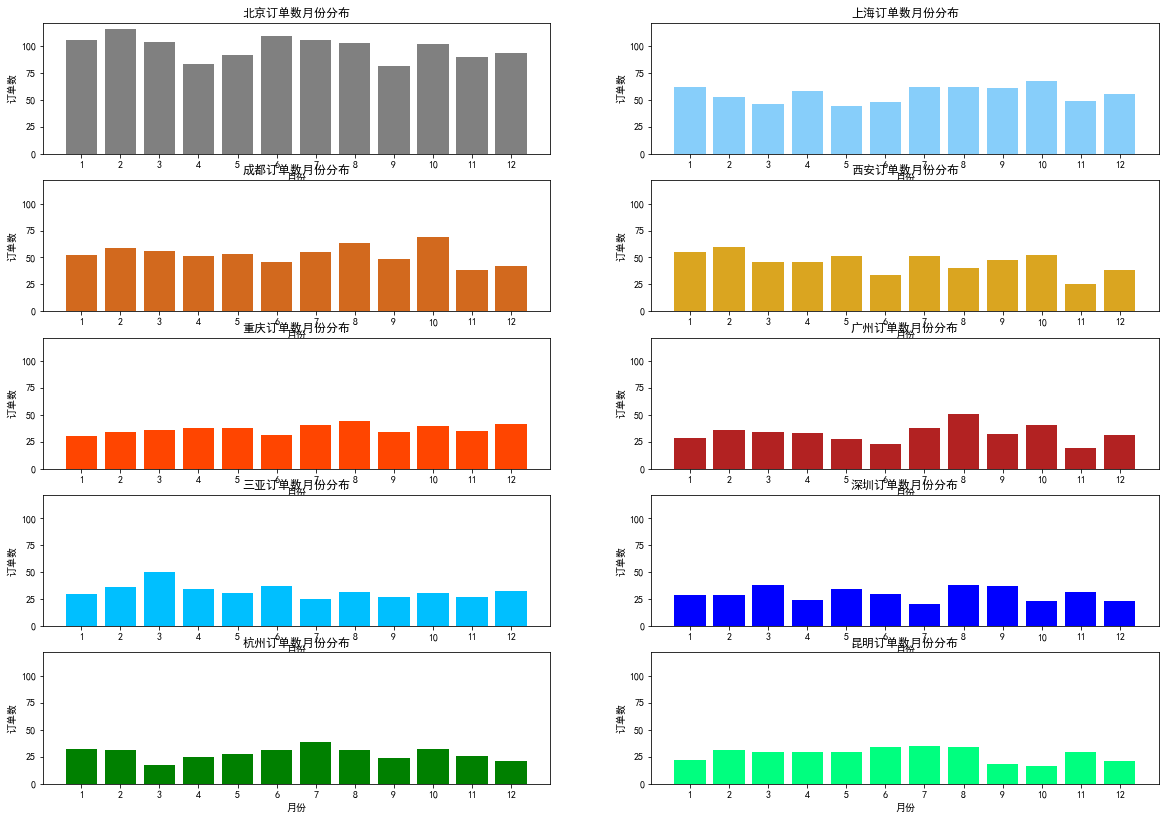

In [473]:
fig = plt.figure(figsize=(20,14))
label_list = list_order_city_top10
color_list = ['grey','lightskyblue','chocolate','goldenrod','orangered','firebrick','deepskyblue','blue','green','springgreen']
ax = None
for j,city in enumerate(list_order_city_top10):
    if ax is None:
        ax = fig.add_subplot(5,2,j+1)
    else:
        ax = fig.add_subplot(5,2,j+1,sharex=ax,sharey=ax)
    x = df_service_type_each_month.xs(1).index.to_list()
    y = df_user_order_detail[df_user_order_detail['city_name']==city]['book_month'].value_counts().sort_index()
    plt.bar(x,y,color=color_list[j],label=label_list[j])
    plt.xticks(x)
    plt.ylabel('订单数')
    plt.xlabel('月份')
    plt.title(f'{city}订单数月份分布')

##### 租车订单最多的城市top10分别是：北京, 上海, 成都, 西安, 重庆, 广州, 三亚, 深圳, 杭州, 昆明
##### 截止订单最后日期，咸阳机场（西安），美兰机场/凤凰机场（三亚），萧山机场 （杭州）没有通地铁，新闻显示，此局面将在2021年结束，这些城市接送机订单将会有所缩减
##### 三亚，西安的机场接送订单占比很高，而重庆的市内交通是所有订单的重要组成部分
##### 三亚3月订单数明显多于其他月份，杭州3月单数则很少，其他城市订单数随月份变化相对较小